<a href="https://colab.research.google.com/github/Guillaume-mcgill/school/blob/main/COMP551_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Samuel Bernard [260983658]                                                                             
Mohul Sharma [260986320]                                                                  
Guillaume Rodier [260975661]

**IMPORTS:**


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# from Sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import mutual_info_score
from sklearn.datasets import load_svmlight_file, fetch_20newsgroups
from sklearn.linear_model import LogisticRegression as sk_LogisticRegression, SGDClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
import scipy

# plotting and math operations
from math import sqrt
import matplotlib.pyplot as plt

Mounted at /content/drive


# **TASK 1.1 (IMBd):**

FIRST LOAD THE DATA:

In [ ]:
# load the data
ds_vocab = pd.read_csv("/content/drive/MyDrive/COMP551_assignment2/imdb_vocab.csv", header=None)
ds_Train_Bow, y_train = load_svmlight_file("/content/drive/MyDrive/COMP551_assignment2/TrainLabeledBow.feat", dtype='uint8', n_features=89527)
ds_Test_Bow, y_test = load_svmlight_file("/content/drive/MyDrive/COMP551_assignment2/TestLabeledBow.feat", dtype='uint8', n_features=89527)

# convert vocabulary to pandas
imdb_dataframe=pd.DataFrame(ds_vocab)

# convert training set to pandas
ds_Train_Bow = pd.DataFrame(ds_Train_Bow.toarray())
nb_Train = ds_Train_Bow.shape[0]

# convert testing set to pandas
ds_Test_Bow = pd.DataFrame(ds_Test_Bow.toarray())
nb_Test = ds_Test_Bow.shape[0]

# count the number of reviews
nb_of_revs=nb_Train+nb_Test

# map the elements of the ds_vocab 2D array into a 1D array
vocab = []
for word in ds_vocab.to_numpy():
  vocab.append(word[0])

***Exploratory Analysis of The IMDB Dataset***

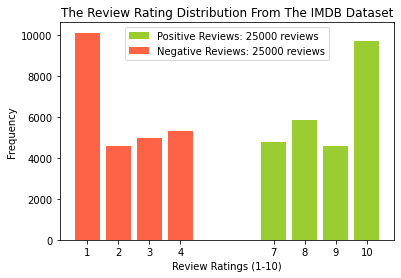

In [ ]:
# displaying a distribution of the review ratings from 1-10
ds_y_combined=np.concatenate((y_train,y_test))
valuepos=(ds_y_combined>5).sum()
valueneg=(ds_y_combined<5).sum()
pos=ds_y_combined[:][ds_y_combined> 5]
neg=ds_y_combined[:][ds_y_combined< 5]
cneg=['tomato']
cpos=['yellowgreen']

labels,counts=np.unique(ds_y_combined,return_counts=True)
labelspos, countsp = np.unique(pos, return_counts=True)
labelsneg,countsn=np.unique(neg,return_counts=True)

plt.bar(labelspos, countsp, align='center', color=cpos)
plt.bar(labelsneg,countsn,align='center',color=cneg)
plt.gca().set_xticks(labels)

plt.legend(['Positive Reviews: '+str(valuepos)+' reviews','Negative Reviews: '+str(valueneg)+' reviews'])
plt.xlabel('Review Ratings (1-10)')
plt.ylabel('Frequency')
plt.title('The Review Rating Distribution From The IMDB Dataset')
plt.show()

CLEAN THE LOADED DATA:

***1st filter ('rare' and stopwords):***

In [ ]:
# in how many documents does each word appear? (in the training set)
ds_train_tok=np.count_nonzero(ds_Train_Bow, axis=0)
ds_test_tok=np.count_nonzero(ds_Test_Bow, axis=0)
merged=np.array(ds_train_tok+ds_test_tok)

# Finding the indices of the stop words
index1p,index50p=0.01*nb_of_revs,0.50*nb_of_revs
index=np.where((merged>index50p) | (merged<index1p))
remove_words=index[0].tolist()


# filter the training set
ds_Train_Bow=ds_Train_Bow.drop(remove_words, axis=1)

# filter the testing set
ds_Test_Bow=ds_Test_Bow.drop(remove_words,axis=1)

# filter the vocabulary
imdb_dataframe=imdb_dataframe.drop(remove_words)

***2nd filter (Z-score):***

In [ ]:
ds_train_tokn=ds_Train_Bow.to_numpy()
ds_test_tokn=ds_Test_Bow.to_numpy()

# standardizing the input features and the response
xcopy=np.zeros(ds_train_tokn.shape)
for i in range(len(ds_train_tokn[0])):
  xcopy[:,i]=np.around((ds_train_tokn[:,i]-np.average(ds_train_tokn[:,i]))/np.std(ds_train_tokn[:,i]-np.average(ds_train_tokn[:,i])),5)

ynew_train=np.copy(y_train)
ycopy=np.around((ynew_train-np.average(ynew_train))/np.std(ynew_train-np.average(ynew_train)),5)

# calculating the z-scores
xT=xcopy.transpose()
z_score=np.matmul(xT,ycopy)/np.sqrt(nb_Train)
abs_zscore=np.absolute(z_score)
best_z=(np.argsort(abs_zscore)[::-1])[:100]

# keeping the best features
imdb_indices=list(imdb_dataframe.index.values)
imdb_features=(np.array(imdb_indices))[:][best_z]
ds_Train_Bow=ds_Train_Bow[:][imdb_features]
ds_Test_Bow=ds_Test_Bow[:][imdb_features]

# does the selected features make sense? Let's print them:
imdb_indx_feat=imdb_features.tolist()
imdb_array=imdb_dataframe.values.tolist() # make a list of all features kept after stopword and rare word filter

posVocab=[]
posInd = []
posZS = []
negVocab=[]
negInd = []
negZS = []

i=0
for value in best_z: # iterate through all the best values to find those that are positive and negative
  if z_score[value]>=0:
    posVocab.append(''.join(imdb_array[value])) # make a list of all most positive z-scores
    posInd.append(imdb_indx_feat[i])
    posZS.append(z_score[value])
  elif z_score[value]<0:
    negVocab.append(''.join(imdb_array[value])) # make a list of all most positive z-scores
    negInd.append(imdb_indx_feat[i])
    negZS.append(z_score[value])
  i+=1

print(f"Out of 100 best z_Score vocabulary words, {len(posVocab)} of them were found to be positive words.")
print(f"Out of 100 best z_Score vocabulary words, {len(negVocab)} of them were found to be negative words.")

posVocab=posVocab[:10]
negVocab=negVocab[:10]
posInd=posInd[:10]
negInd=negInd[:10]
posZS=posZS[:10]
negZS=negZS[:10]
indices_of_best = negInd + posInd
print(f"Out of 100 best z_Score vocabulary words, the top 10 positive z_score vocabulary words are the following: {posVocab}")
print(f"and the top 10 negative z_score vocabulary words are the following: {negVocab}")

Out of 100 best z_Score vocabulary words, 36 of them were found to be positive words.
Out of 100 best z_Score vocabulary words, 64 of them were found to be negative words.
Out of 100 best z_Score vocabulary words, the top 10 positive z_score vocabulary words are the following: ['great', 'wonderful', 'excellent', 'best', 'love', 'amazing', 'loved', 'perfect', 'favorite', 'beautiful']
and the top 10 negative z_score vocabulary words are the following: ['bad', 'worst', 'waste', 'awful', '?', 'terrible', 'worse', 'no', 'horrible', 'stupid']


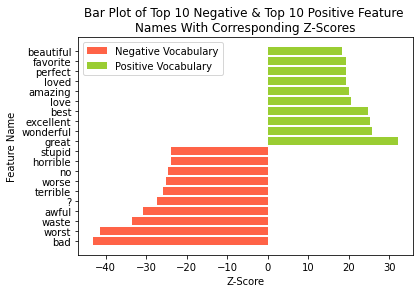

In [ ]:
#Plotting a horizontal bar plot of the top 10 positive words and top 10 negative words, and their corresponding z-scores
plt.barh(negVocab, negZS, align='center', color='tomato')
plt.barh(posVocab, posZS, align='center', color='yellowgreen')
plt.title('Bar Plot of Top 10 Negative & Top 10 Positive Feature \nNames With Corresponding Z-Scores')
plt.legend(['Negative Vocabulary', 'Positive Vocabulary'])
plt.xlabel('Z-Score')
plt.ylabel('Feature Name')
plt.show()

# **TASK 1.2 (20 News Groups):**

FIRST LOAD THE DATA

In [ ]:
categories=['comp.graphics','rec.sport.hockey','sci.med','soc.religion.christian']

# Fetch the training data
trainData = fetch_20newsgroups(subset='train', categories=categories, remove=(['headers','footers','quotes']), shuffle=True, random_state=551)

# Fetch the testing data
testData = fetch_20newsgroups(subset='test', categories=categories, remove=(['headers','footers','quotes']), shuffle=True, random_state=551)

# Fetch all the data
allData = fetch_20newsgroups(subset='all', categories=categories, remove=(['headers','footers','quotes']), shuffle=True, random_state=551)

# Initialize the count vectorizer
count_vect = CountVectorizer()

# create a first word index for all the data for exploratory analysis
x_all_counts = count_vect.fit_transform(allData.data)

# create a second word index to fit/transform the training data and transform the test data
x_train_counts = count_vect.fit_transform(trainData.data)
x_test_counts = count_vect.transform(testData.data)


y_train_NewsGroup = trainData.target
y_test_NewsGroup = testData.target
y_all_NewsGroup = allData.target

# create a pandas dataframe with final x components
x_all_NewsGroup = pd.DataFrame(x_all_counts.toarray())
x_train_NewsGroup = pd.DataFrame(x_train_counts.toarray())
x_test_NewsGroup = pd.DataFrame(x_test_counts.toarray())


APPLY ONE HOT ENCODING ON Y:

In [ ]:
# instantiate the OneHotEncoder function to turn four labels into arrays
encoder = OneHotEncoder()

# fit to transform on the train data
encoded_train = encoder.fit_transform(pd.DataFrame(y_train_NewsGroup))
encoded_train = encoded_train.toarray()

# transform the test data on the training data
encoded_test = encoder.transform(pd.DataFrame(y_test_NewsGroup))
encoded_test = encoded_test.toarray()


EXPLORATORY ANALYSIS FOR 20NEWSGROUP:

In [ ]:
print(f"The total amount of features for training plus testing is: {x_all_NewsGroup.shape[1]}")
print(f"However, we are transforming the testing data on the training data, so the number of features becomes: {x_train_NewsGroup.shape[1]}")

The total amount of features for training plus testing is: 40373
However, we are transforming the testing data on the training data, so the number of features becomes: 30945


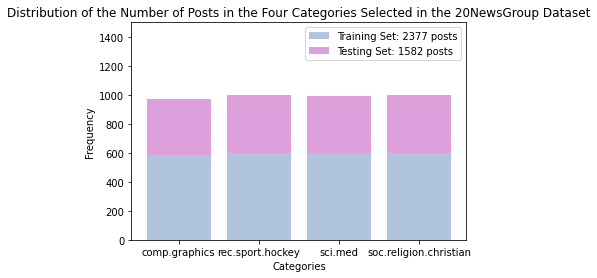

From combined testing and training sets,
There are 973 posts from the comp.graphics category.
There are 999 posts from the rec.sport.hockey category.
There are 990 posts from the sci.med category.
There are 997 posts from the soc.religion.christian category.


In [ ]:
# displaying a distribution of the number of posts in the Four Categories Selected in the 20NewsGroup Dataset
count_test=np.count_nonzero(encoded_test,axis=0)
count_train=np.count_nonzero(encoded_train,axis=0)
encoded_combined=np.concatenate((encoded_train,encoded_test))
count=np.count_nonzero(encoded_combined,axis=0)
name4=encoder.get_feature_names_out()

c=['lightsteelblue','plum']
cat=np.arange(len(categories))
plt.bar(cat,count_train,align='center',color=c[0])
plt.bar(cat,count_test,align='center',color=c[1],bottom=count_train)

plt.xticks(cat,categories)
plt.legend(['Training Set: '+str(x_train_NewsGroup.shape[0])+' posts', 'Testing Set: '+str(x_test_NewsGroup.shape[0])+' posts'])

plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Distribution of the Number of Posts in the Four Categories Selected in the 20NewsGroup Dataset')
plt.ylim((0, 1500))
plt.show()

print(f'From combined testing and training sets,')
for x in range(len(count)):
  print(f"There are {count[x]} posts from the {categories[x]} category.")

***1st filter ('rare' and stopwords):***

In [ ]:
# define constants
nb_of_lines = x_all_NewsGroup.shape[0]
index1p, index50p = 0.01*nb_of_lines, 0.50*nb_of_lines                          # numb of occurences to consider as extremum

# total occurence of each word
train_count=np.count_nonzero(x_train_NewsGroup, axis=0)
test_count=np.count_nonzero(x_test_NewsGroup, axis=0)
merged=np.array(train_count+test_count)

# find indices to remove
index=np.where((merged>index50p) | (merged<index1p))
remove_words=index[0].tolist()

# remove word features from initial datasets
x_train_NewsGroup, x_test_NewsGroup = x_train_NewsGroup.drop(remove_words, axis=1), x_test_NewsGroup.drop(remove_words,axis=1)
x_all_NewsGroup = x_all_NewsGroup.drop(remove_words, axis=1)

***2nd filter (select best features with MI):***

In [ ]:
# get the best features
mIS = [0]*x_train_NewsGroup.shape[0]
best_feats_ordered=[0]*4
best_feats = [0]*4
for y in range(len(encoded_train[1])):
  i=0
  for column in range(x_train_NewsGroup.shape[1]):  # for each feature, calculate Mutual Information (MI)
    mIS[column] = mutual_info_score(labels_true=encoded_train[:,y], labels_pred=x_train_NewsGroup.to_numpy()[:,column])
    i+=1
  best_feats_ordered[y]=((np.argsort(mIS)[::-1])[:5]).tolist() # find the 5 best values for each category
  best_feats[y] = set((np.argsort(mIS)[::-1])[:100]) # find the 100 best features for each category and make a set
select_feat = list(best_feats[0].union(best_feats[1]).union(best_feats[2]).union(best_feats[3])) # merge the 4 sets into 1 while removing any duplicate

#Find the 20 best values for the heat map
best5_feat=[] #store the 5 best MIS from each category
for num in best_feats_ordered:
  for x in num:
    best5_feat.append(x)

newl=[] #store the tokenized words values
for x in best5_feat:
  newl.append(x_train_NewsGroup.columns[x])

print(f'Here are the best 20 features, 5 from each category: {count_vect.get_feature_names_out()[newl]}')

# only keep the best features in the initial arrays
best_features=[]
for x in select_feat:
  best_features.append(x_train_NewsGroup.columns[x])

x_train_NewsGroup=x_train_NewsGroup[:][best_features]
x_test_NewsGroup=x_test_NewsGroup[:][best_features]


Here are the best 20 features, 5 from each category: ['graphics' 'he' 'who' 'files' 'file' 'team' 'game' 'hockey' 'season'
 'nhl' 'banks' 'gordon' 'geb' 'chastity' 'n3jxp' 'god' 'jesus' 'christ'
 'bible' 'christians']


,20943,133,20989,21085,21097,21109,21155,21414,21438,1018,...,20156,20171,20276,20406,20410,20433,20637,20667,20933,20935
0,0,0,0,0,0,2,0,0,0,0,...,2,1,2,2,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2372,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2373,0,0,0,0,0,1,0,0,0,0,...,6,1,4,1,0,0,0,0,0,0
2374,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0
2375,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


# **TASK 2: Implement Logistic and Multiclass classifiers**

HELPER FUNCTIONS:

In [ ]:
# LOGISTIC FUNC:
logistic = lambda z: 1./(1 + np.exp(-z))

# ACCURACCY CHECKING:
def accuracy(y, y_pred):
  y=np.array(y)
  y_pred=np.array(y_pred)
  accuracy = sum(np.array(y_pred.argmax(axis=1) == y.argmax(axis=1)))
  accuracy /= y.shape[0]
  return accuracy

***Logistic regression:***

In [ ]:
class LogisticRegression:

  def __init__(self, numIter=1000, stepSize=0.001, tolerance=1e-4): #Set the maximal number of iterations, step size, and tolerance
    self.numbIter = numIter
    self.stepSize = stepSize
    self.tolerance = tolerance

  def gradient(self, ypred): #Calculating the gradient
    return np.matmul(np.transpose(self.x), ypred-self.y)/len(self.x)

  def ce(self,a): #calculating cross entropy for logistic regression
      return np.sum(self.y*np.log1p(np.exp(-a))+(1-self.y)*np.log1p(np.exp(a)))

  def fit(self, x, y):
    self.x = np.array(x)
    self.y = np.array(y)
    self.w = np.zeros(len(self.x[0]))
    grad_norm = np.inf # set an initial large value to gradient norm
    iteration = 0
    iter_list = [] #store each iteration
    ce_list = [] #store each cross entropy score at each iteration

    while (grad_norm>self.tolerance and iteration<self.numbIter): # implement gradient descent until the tolerance is reached or maximal number of iteration is reach
      a = np.matmul(self.x, np.transpose(self.w)) #calculate a=x*w
      ce = self.ce(a) # find the cross entropy for a
      iter_list.append(iteration)
      ce_list.append(ce)
      y_pred = logistic(a) # find the prediction for a
      grad = self.gradient(y_pred) # perform gradient calculation on that prediction
      self.w -= self.stepSize*grad # modify the weights
      grad_norm = np.linalg.norm(grad) # calculate gradient norm
      iteration += 1

    return iter_list, ce_list, self.w

  def predict(self,x): # predict using logistic function
    a = np.matmul(x, np.transpose(self.w))
    y_pred = logistic(a)
    return y_pred

  def gradient_check(self,x,y): # gradient check to verify that our gradient calculation is correct
    w = self.w.copy()
    N,D=x.shape
    epsilon = np.random.randn(1)[0] * self.tolerance # initalize epsilon
    diff=np.zeros((D,1))

    self.w=self.w+epsilon # find J1 and reset w
    a1 = np.matmul(self.w,x.transpose())
    J1=self.ce(a1)
    self.w=w

    self.w=self.w-epsilon # find J2 and reset w
    a2 = np.matmul(self.w,x.transpose())
    J2=self.ce(a2)
    self.w=w

    dw_num = (J1 - J2)/(2*epsilon) # numerical gradient calculation

    yh = 1/(1+np.exp(-np.matmul(x, w.transpose())))
    dw_cal =np.sum(np.matmul(x.transpose(),(yh - y))) # derived gradient calculation

    diff=np.square(dw_cal - dw_num).sum()/np.square(dw_cal + dw_num).sum()

    return diff

***Multiclass regression:***

In [ ]:
class MulticlassRegression:

  def __init__(self, numIter=1000, stepSize=0.0001, tolerance=1e-4):            # set parameters given as arguments
    self.numIter = numIter
    self.stepSize = stepSize
    self.tolerance = tolerance

  def gradient(self, y_pred):
    return np.matmul(np.transpose(self.x), y_pred-self.y)

  def fit(self, x, y):
    self.x = np.array(x)                                                        # convert the x and y arrays to numpy
    self.y = np.array(y)
    self.w = np.zeros((len(self.x[1]), len(self.y[1])))                         # starting weight array before regression

    grad_norm = np.inf                                                          # start with large norm so that the while loop executes in first iteration
    iteration = 0
    iter_list = []                                                              # keep track of cross entropy and iteration
    ce_list = []

    while (grad_norm>self.tolerance and iteration<self.numIter):
      a = np.matmul(self.x, self.w)
      iter_list.append(iteration)
      y_pred = np.exp(a)/np.exp(a).sum(axis=1).reshape(self.x.shape[0],1)
      grad = self.gradient(y_pred)/len(self.x)
      self.w -= self.stepSize*grad
      grad_norm = np.linalg.norm(grad)
      iteration += 1
      iteration_loss = self.ce()
      ce_list.append(iteration_loss)
      # print(f"iter {iteration}: {iteration_loss:.3f}")
    return iter_list, ce_list, self.w

  def predict(self, x):
    x = np.array(x)
    a = np.matmul(x, self.w)
    y_pred = np.exp(a)/np.exp(a).sum(axis=1).reshape(x.shape[0],1)
    return y_pred

  def ce(self):
    a = np.matmul(self.x, self.w)
    exp1= np.exp(a)
    exp2= np.exp(a).sum(axis=1).reshape(self.x.shape[0],1)
    return -np.sum(self.y*(np.log(exp1)-np.log(exp2)))/len(self.x)                          # separate log division in a substraction to avoid NaN values

  def gradient_check(self):
    numClass = self.y.shape[1]
    numFeat = self.x.shape[1]

    diff = np.zeros((numFeat, numClass))                                        # matrix that will keep track of all the gradient differences

    w = self.w.copy()

    for i in range(numFeat):
        for j in range(numClass):
            epsilon = np.zeros((numFeat, numClass))
            epsilon[i, j] = np.random.rand()*1e-4

            self.w = self.w + epsilon
            J1 = self.ce()
            self.w = w

            self.w = self.w - epsilon
            J2 = self.ce()
            self.w = w

            numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
            derived_grad = self.gradient(self.predict(self.x))[i, j]
            diff[i, j] = np.square(derived_grad - numeric_grad) / np.square(derived_grad + numeric_grad)

    return diff.sum()

# **TASK 3: Run Experiments**

***Predict on the IMBd Dataset:***

In [ ]:
#Turning numerical ratings into 0's and 1's based on whether the rating is negative or positive
yTrain = (np.array(y_train[:])>5).astype(int)
yTest = (np.array(y_train[:])>5).astype(int)

#Below, we will be comparing the Logistic Regression function to KNN
#First, we need to find the best K value for the IMDB dataset by seperating the training dataset into training and validation, as shown below
indices_valid = (np.random.permutation(ds_Train_Bow.shape[0]))[:int(ds_Train_Bow.shape[0]*0.25)]
indices_train = (np.random.permutation(ds_Train_Bow.shape[0]))[int(ds_Train_Bow.shape[0]*0.25):]
train_x = pd.DataFrame(np.array(ds_Train_Bow.copy().iloc[list(indices_train)]))
valid_x = pd.DataFrame(np.array(ds_Train_Bow.copy().iloc[list(indices_valid)]))

train_y = np.zeros(len(indices_train))
for i in range(len(train_y)):
  train_y[i] = yTrain[indices_train[i]]

valid_y = np.zeros(len(indices_valid))
for i in range(len(valid_y)):
  valid_y[i] = yTrain[indices_valid[i]]

#Below, we loop through values of K between 1 and 15 and append the validation accuracies of each K into the knn_accs array
knn_accs = []
for k in range(1, 15):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(train_x, train_y)
  y_pred = knn.predict(valid_x)
  acc = 0
  for i in range(len(valid_y)):
    if valid_y[i] == y_pred[i]:
      acc = acc + 1
  knn_accs.append(acc/len(valid_y))

#Find the k-value corresponding to the highest observed validation accuracy
best_k = np.argmax(np.array(knn_accs))+1

#The function below will graph the ROCs for the IMDB dataset with four different algorithms: our logistic regression function, and Sklearn's logistic regression, Stochastic Gradient Descent (SGD), and KNN algorithms
#It takes inputs maximum number of iterations (max_iter), step size value alpha, tolerance value, as well as the fraction of training data to be used (if show != 'no', the graph will be displayed)
def graphingROC_IMDB(max_iter, alpha, tol, fraction_training=1, show = 'no'):
  #Turning numerical ratings into 0's and 1's based on whether the rating is negative or positive
  yTrain = (np.array(y_train[:])>5).astype(int)
  yTest = (np.array(y_train[:])>5).astype(int)

  #Below, we randomly select the specific fraction of training data that was inputed by the user
  np.random.seed(1234)
  indices_array = (np.random.permutation(ds_Train_Bow.shape[0]))[:int(ds_Train_Bow.shape[0]*fraction_training)]
  training_x = pd.DataFrame(np.array(ds_Train_Bow.copy().iloc[list(indices_array)]))
  training_y = np.zeros(len(indices_array))
  for i in range(len(training_y)):
    training_y[i] = yTrain[indices_array[i]]

  #Perform logistic regression with given parameters
  logist_reg = LogisticRegression(numIter = max_iter, stepSize = alpha, tolerance = tol)
  logist_reg.fit(x=training_x, y=training_y)
  y_pred1 = logist_reg.predict(ds_Test_Bow)

  #Perform Sklearn's KNN algorithm with the optimal k-value found previously
  knn = KNeighborsClassifier(n_neighbors=best_k)
  knn.fit(training_x, training_y)
  y_pred2 = knn.predict(ds_Test_Bow)

  #Perform Sklearn's Stochastic Gradient descent algorithm, which takes the same paramters as Logistic Regression
  sk_logist_reg = SGDClassifier(max_iter=max_iter, alpha=alpha, tol=tol)
  sk_logist_reg.fit(X = training_x, y = training_y)
  y_pred3 = sk_logist_reg.predict(X = ds_Test_Bow)

  #Perform sklearn's logistic regression, which only takes the parameter max_iter (cannot choose a specific learning rate or tolerance)
  sk_logist_reg = sk_LogisticRegression(max_iter=max_iter)
  sk_logist_reg.fit(X = training_x, y = training_y)
  y_pred4 = sk_logist_reg.predict(X = ds_Test_Bow)

  #Plot the ROCs of the 4 algorithms, and find corresponding AUROCs
  plt.clf()
  fpr1, tpr1, _= roc_curve(yTest, y_pred1)
  auroc1 = roc_auc_score(yTest, y_pred1)
  plt.plot(fpr1,tpr1,'lightsteelblue', label="Logistic Regression")
  plt.text(0.4, 0.1, "Logistic Regression AUC " + str(round(auroc1,2)))

  fpr2, tpr2, _ = roc_curve(yTest,y_pred2)
  auroc2 = roc_auc_score(yTest, y_pred2)
  plt.plot(fpr2,tpr2,'plum', label=('Sklearn KNN (K='+str(best_k)+')'))
  plt.text(0.4, 0.2, "Sklearn KNN AUC " + str(round(auroc2,2)))

  fpr3, tpr3, _ = roc_curve(yTest,y_pred3)
  auroc3 = roc_auc_score(yTest, y_pred3)
  plt.plot(fpr3,tpr3, 'yellowgreen', label="Sklearn SGD")
  plt.text(0.4, 0.3, "Sklearn SGD AUC " + str(round(auroc3,2)))

  fpr4, tpr4, _ = roc_curve(yTest, y_pred4)
  auroc4 = roc_auc_score(yTest, y_pred4)
  plt.plot(fpr4,tpr4,'sandybrown', label="Sklearn Logistic Regression")
  plt.text(0.4, 0.4, "Sklearn Logistic Regression AUC " + str(round(auroc4,2)))
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title('ROC movie sentiment prediction with Max. Iter = ' + str(max_iter) + ',\nalpha = ' + str(alpha) + ', and tolerance = ' + str(tol) + ' using ' + str(fraction_training*100) + '% of the training data')
  plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
  if show == 'no': #If show == 'no', do not display the graph
    plt.close()

  return (round(auroc1,2)), (round(auroc2,2)), (round(auroc3,2)), (round(auroc4,2)) #Function returns the AUROCs of the 4 algorithms

Predicting with different fractions of training dataset:

In [ ]:
lr_auroc = [] #List of AUROCs for our logistic regression algorithm
knn_auroc = [] #List of AUROCs for our KNN algorithm
graph1 = graphingROC_IMDB(max_iter=1000, alpha=0.01, tol=1e-3, fraction_training=0.2) #Only 20% of training data is used for prediction
lr_auroc.append(graph1[0]) #Add Linear Regression AUROC to the lr_auroc list
knn_auroc.append(graph1[1]) #Add KNN AUROC to the knn_auroc list

In [ ]:
graph2 = graphingROC_IMDB(max_iter=1000, alpha=0.01, tol=1e-3, fraction_training=0.4) #40% of training data is used
lr_auroc.append(graph2[0])
knn_auroc.append(graph2[1])

In [ ]:
graph3 = graphingROC_IMDB(max_iter=1000, alpha=0.01, tol=1e-3, fraction_training=0.6) #60% of training data is used
lr_auroc.append(graph3[0])
knn_auroc.append(graph3[1])

In [ ]:
graph4 = graphingROC_IMDB(max_iter=1000, alpha=0.01, tol=1e-3, fraction_training=0.8) #80% of training data is used
lr_auroc.append(graph4[0])
knn_auroc.append(graph4[1])

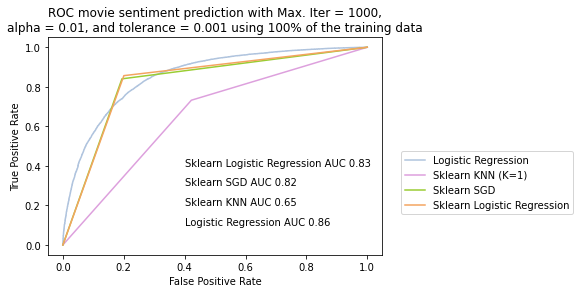

In [ ]:
graph5= graphingROC_IMDB(max_iter=1000, alpha=0.01, tol=1e-3, fraction_training=1, show='yes') #100% of training data is used, and graph is displayed
lr_auroc.append(graph5[0])
knn_auroc.append(graph5[1])


In [ ]:
# Gradient check
yTrain = (np.array(y_train[:])>5).astype(int)
logist=LogisticRegression()
logist.fit(ds_Train_Bow,yTrain)
grad=logist.gradient_check(ds_Train_Bow.to_numpy(),yTrain)
print(f'The gradient check: {grad}')

The gradient check: 3.1763695195691243e-16


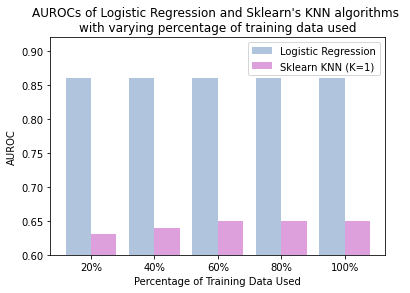

In [ ]:
#Below, we are making a bar plot of the AUROCs for KNN and logistic regression as a function of the amount of training data used
training_percentages = ['20%','40%','60%','80%', '100%']

x = np.arange(len(training_percentages))

plt.bar(x - 0.2, lr_auroc, 0.4, label = 'Logistic Regression', color = 'lightsteelblue')
plt.bar(x + 0.2, knn_auroc, 0.4, label = ('Sklearn KNN (K='+str(best_k)+')'), color = 'plum')

plt.xticks(x, training_percentages)
plt.xlabel("Percentage of Training Data Used")
plt.ylabel("AUROC")
plt.title("AUROCs of Logistic Regression and Sklearn's KNN algorithms \nwith varying percentage of training data used")
plt.ylim(0.6, 0.92)
plt.legend()
plt.show()

Implementing Linear Regression to predict the ratings of the IMDb test data:

In [ ]:
from sklearn.linear_model import LinearRegression

#The function below will use sklearn's linear regression algorithm and attempt to predict the ratings of the testing data with varying percentage of training data used
def sk_linear_reg(train_x, train_y, test_x, test_y, fraction_training):
  np.random.seed(1234)
  indices_array = (np.random.permutation(train_x.shape[0]))[:int(train_x.shape[0]*fraction_training)]
  training_x = pd.DataFrame(np.array(train_x.copy().iloc[list(indices_array)]))
  training_y = np.zeros(len(indices_array))
  for i in range(len(training_y)):
    training_y[i] = train_y[indices_array[i]]

  #Conduct linear regression
  LR = LinearRegression()
  LR.fit(X = training_x, y = training_y)
  y_pred = np.around(LR.predict(test_x), 0)
  test_pred = []
  for i in range(len(y_pred)):
    test_pred.append((test_y[i]-y_pred[i])**2)
  rmse = np.sqrt(np.average(np.array(test_pred)))
  return rmse/(10-1) #Function returns the Normalized Root Mean Squared Error observed (dividing by 10-1 involves normalizing the rmse by dividing by max-min of possible output values)

#Determine RMSE with varying percentage of training data used
percentages = [20, 40, 60, 80, 100]
rmse = []
for percent in percentages:
  rmse.append(sk_linear_reg(ds_Train_Bow, y_train, ds_Test_Bow, y_test, percent/100))

#Determine RMSE with varying percentage of training data used, but only with the top 10 negative features and top 10 positive
rmse_best_feat = []
for percent in percentages:
  rmse_best_feat.append(sk_linear_reg(ds_Train_Bow[:][indices_of_best], y_train, ds_Test_Bow[:][indices_of_best], y_test, percent/100))

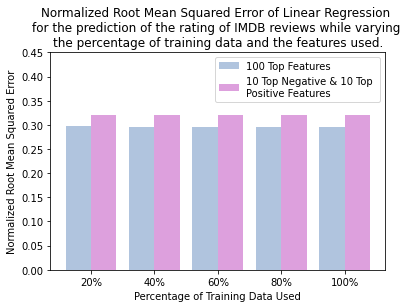

In [ ]:
#Plotting the Normalized RMSEs obtained above
plt.bar(x - 0.2, np.array(rmse), 0.4, label = '100 Top Features', color = 'lightsteelblue')
plt.bar(x + 0.2, np.array(rmse_best_feat), 0.4, label = '10 Top Negative & 10 Top \nPositive Features', color = 'plum')

plt.xticks(x, training_percentages)
plt.xlabel("Percentage of Training Data Used")
plt.ylabel("Normalized Root Mean Squared Error")
plt.title("Normalized Root Mean Squared Error of Linear Regression \nfor the prediction of the rating of IMDB reviews while varying \nthe percentage of training data and the features used.")
plt.ylim(0, 0.45)
plt.legend()
plt.show()

Determining the weights of the top 10 positive and top 10 negative features:

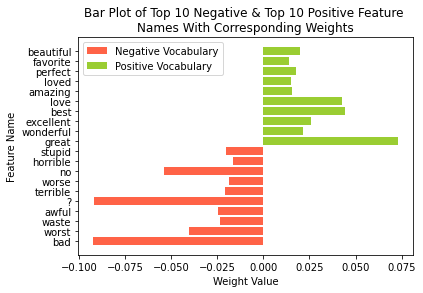

In [ ]:
#Turning numerical ratings into 0's and 1's based on whether the rating is negative or positive
yTrain = (np.array(y_train[:])>5).astype(int)
yTest = (np.array(y_train[:])>5).astype(int)

logist_reg = LogisticRegression()
w = (logist_reg.fit(x=ds_Train_Bow[:][indices_of_best], y=yTrain))[2] #Find weights for the top 10 negative and top 10 positive features
#Plotting weights of each words below
plt.barh(negVocab, w[0:10], align='center', color='tomato')
plt.barh(posVocab, w[10:20], align='center', color='yellowgreen')
plt.title('Bar Plot of Top 10 Negative & Top 10 Positive Feature \nNames With Corresponding Weights')
plt.legend(['Negative Vocabulary', 'Positive Vocabulary'])
plt.xlabel('Weight Value')
plt.ylabel('Feature Name')
plt.show()

Testing different step size values:

In [ ]:
yTrain = (np.array(y_train[:])>5).astype(int)
yTest = (np.array(y_train[:])>5).astype(int)

#Below, we find the AUROCs of the logistic regression algorithm with varying step size alpha
alphas = [1, 0.1, 0.001, 0.0001]
aurocs = []
for alpha in alphas:
  logist_reg = LogisticRegression(numIter=1000, stepSize=alpha, tolerance = 1e-1)
  logist_reg.fit(x=ds_Train_Bow, y=yTrain)
  y_pred = logist_reg.predict(ds_Test_Bow)
  auroc = roc_auc_score(yTest, y_pred)
  aurocs.append(auroc)

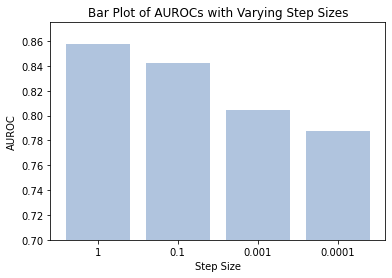

In [ ]:
#Below, we plot a bar plot with the AUROCs obtained with each step size value
for i in range(len(alphas)):
  alphas[i] = str(alphas[i])
plt.bar(alphas, aurocs, color = 'lightsteelblue')
plt.title('Bar Plot of AUROCs with Varying Step Sizes')
plt.ylim((0.7, 0.875))
plt.xlabel('Step Size')
plt.ylabel('AUROC')
plt.show()

Convergence plot for logistic regression:

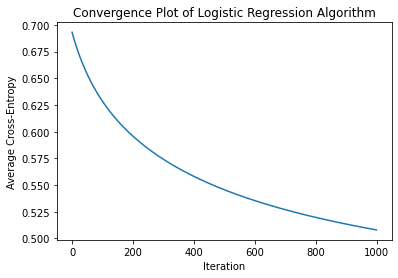

In [ ]:
#Below, we are plotting the convergence plot for the logistic regression algorithm
yTrain = (np.array(y_train[:])>5).astype(int)
logist_reg = LogisticRegression(numIter=1000, stepSize=0.01, tolerance = 1e-4)
b = logist_reg.fit(x=ds_Train_Bow, y=yTrain)
plt.plot(b[0], np.array(b[1])/len(yTrain))
plt.xlabel('Iteration')
plt.ylabel('Average Cross-Entropy')
plt.title('Convergence Plot of Logistic Regression Algorithm')
plt.show()

***`Predict on the NewsGroup Dataset:`***



In [ ]:
#As done previously for the IMDB dataset, the following code is generated to find the best k value by seperating the training dataset into training and validation sets
indices_valid = (np.random.permutation(x_train_NewsGroup.shape[0]))[:int(x_train_NewsGroup.shape[0]*0.25)]
indices_train = (np.random.permutation(x_train_NewsGroup.shape[0]))[int(x_train_NewsGroup.shape[0]*0.25):]
train_x = pd.DataFrame(np.array(pd.DataFrame(x_train_NewsGroup).iloc[list(indices_train)]))
valid_x = pd.DataFrame(np.array(pd.DataFrame(x_train_NewsGroup).iloc[list(indices_valid)]))

train_y = [0]*(len(indices_train))
for i in range(len(indices_train)):
  train_y[i] = list(encoded_train[indices_train[i]])

valid_y = [0]*(len(indices_valid))
for i in range(len(indices_valid)):
  valid_y[i] = list(encoded_train[indices_valid[i]])

knn_accs = []
for k in range(1, 15):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(train_x, train_y)
  y_pred1 = knn.predict(valid_x)
  acc = accuracy(y=valid_y, y_pred=y_pred1)
  knn_accs.append(acc)

best_k = np.argmax(np.array(knn_accs))+1

#The function below returns the accuracies observed for the prediction of the testing set of the NewsGroup data, conducted with the multiclass regression and sklearn's KNN algorithm
def multiclass_KNN_acc_NewsGroup(max_iter, alpha, tol, fraction_training=1):
  #Below, we randomly select the specific fraction of training data that was inputed by the user
  np.random.seed(1234)
  indices_array = (np.random.permutation(x_train_NewsGroup.shape[0]))[:int(x_train_NewsGroup.shape[0]*fraction_training)]
  training_x = pd.DataFrame(np.array(pd.DataFrame(x_train_NewsGroup).iloc[list(indices_array)]))
  training_y = [0]*(len(indices_array))
  for i in range(len(training_y)):
    training_y[i] = list(encoded_train[indices_array[i]])

  multi_Reg = MulticlassRegression() #Conduct multiclass regression
  multi_Reg.fit(x=training_x, y=training_y)
  y_pred3 = multi_Reg.predict(x_test_NewsGroup)
  y_pred3 = (y_pred3>0.5).astype(int)

  knn = KNeighborsClassifier(n_neighbors=best_k) #Conduct KNN
  knn.fit(training_x, training_y)
  y_pred4 = knn.predict(x_test_NewsGroup)

  accuracy_multiclass = accuracy(y=encoded_test, y_pred=y_pred3) #Determine the accuracy of multiclass regression
  accuracy_KNN = accuracy(y=encoded_test,y_pred=y_pred4) #Determine the accuracy of the sklearn's KNN algorithm

  return accuracy_multiclass, accuracy_KNN #Return accuracies

Predicting with different fractions of training data:

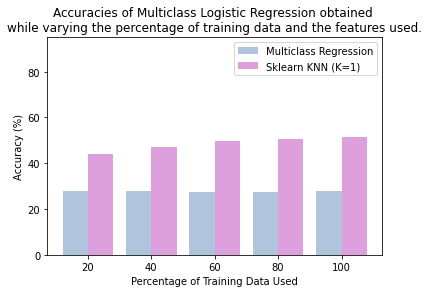

In [ ]:
percentages = [20, 40, 60, 80, 100]
multiclass_acc = []
knn_acc = []
#Determine the multiclass and KNN prediction accuracies with varying percentages of training data used
for percent in percentages:
  acc = multiclass_KNN_acc_NewsGroup(1000, 0.0001, 1e-4, fraction_training=percent/100)
  multiclass_acc.append(acc[0])
  knn_acc.append(acc[1])

#Plot the accuracies as a function of the percentage of training data used
plt.bar(x - 0.2, np.array(multiclass_acc)*100, 0.4, label = 'Multiclass Regression', color = 'lightsteelblue')
plt.bar(x + 0.2, np.array(knn_acc)*100, 0.4, label = ('Sklearn KNN (K='+str(best_k)+')'), color = 'plum')

plt.xticks(x, percentages)
plt.xlabel("Percentage of Training Data Used")
plt.ylabel("Accuracy (%)")
plt.title("Accuracies of Multiclass Logistic Regression obtained \nwhile varying the percentage of training data and the features used.")
plt.ylim(0, 95)
plt.legend()
plt.show()

Testing different step size values:

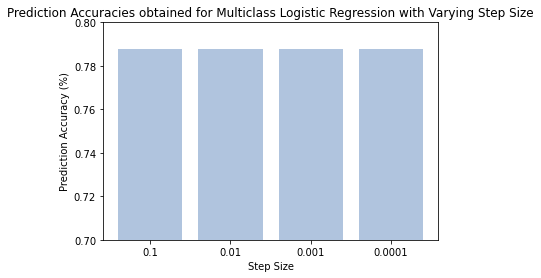

In [ ]:
#Below, we iterate through different values for the step size and perform multiclass regression of the NewsGroup dataset to find corresponding prediction accuracies
alphas = [0.1, 0.01, 0.001, 0.0001]
accs = []
for alpha in alphas:
  multi_reg = MulticlassRegression(numIter=1000, stepSize=alpha, tolerance = 1e-3)
  multi_reg.fit(x=x_train_NewsGroup, y=encoded_train)
  y_pred = multi_reg.predict(x_test_NewsGroup)
  acc = accuracy(y=encoded_test, y_pred=y_pred)
  accs.append(auroc)

#Below, we plot the prediction acccuracies observed with the different alpha values
for i in range(len(alphas)):
  alphas[i] = str(alphas[i])
plt.bar(alphas, accs, color = 'lightsteelblue')
plt.title('Prediction Accuracies obtained for Multiclass Logistic Regression with Varying Step Size')
plt.ylim((0.7, 0.8))
plt.xlabel('Step Size')
plt.ylabel('Prediction Accuracy (%)')
plt.show()

Convergence plot for multiclass regression:

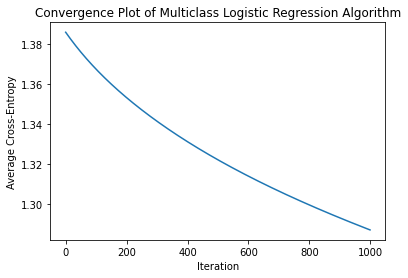

In [ ]:
#Below, we are plotting the convergence plot for the multiclass regression algorithm
multi_Reg = MulticlassRegression()
b = multi_Reg.fit(x=x_train_NewsGroup, y=encoded_train)
plt.plot(b[0], np.array(b[1]))
plt.xlabel('Iteration')
plt.ylabel('Average Cross-Entropy')
plt.title('Convergence Plot of Multiclass Logistic Regression Algorithm')
plt.show()

In [ ]:
# Gradient check for multiclass
gradientCheck = multi_Reg.gradient_check()
print(f'The result of the gradient check is: {gradientCheck}')
# must be small (e.g. 10^-8)

The result of the gradient check is: 1182.0092478778472


Heatmap of feature weights:

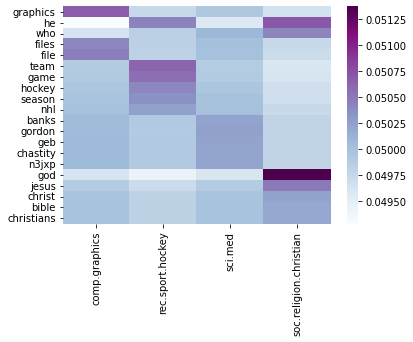

In [ ]:
multi_Reg = MulticlassRegression()
w_hat = multi_Reg.fit(x=x_train_NewsGroup[:][newl], y=encoded_train)[2] #Find the values of w_hat for the 20 best features obtained previously
#Below we transform w_hat
w_hat = np.exp(w_hat)
w_hat = w_hat / w_hat.sum(axis=0)[None,:]
w_hat_df = pd.DataFrame(w_hat, columns=categories, index=count_vect.get_feature_names_out()[newl])

#Create a heatmap of the weight values of the different feature names with the corresponding 4 article types
from seaborn import heatmap
hmp = heatmap(w_hat_df, cmap='BuPu')
fig = hmp.get_figure()